In [1]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import PIL
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,SGD
from sklearn.metrics import mean_squared_error as MSE_SKL
from sklearn.metrics import mean_absolute_error as MAE_SKL
from tensorflow.keras.metrics import mean_absolute_error as MAE_TF
from tensorflow.keras.regularizers import L2
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.models import Model
import os

In [2]:
# Check if tensorflow detectects the gpu or not
if tf.test.gpu_device_name():
    print("Gpu available: {}".format(tf.test.gpu_device_name()))
else:
    print("Tensor Flow has not detected the gpu")

Gpu available: /device:GPU:0


In [3]:
print(plt.style.available)
plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Function to preprocess the image
def preprocess_image(image):
    # Enhance edges using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Apply a bilateral filter to remove noise while keeping edges sharp
    filtered_image = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)
    enhanced_image = cv2.cvtColor(enhanced_image,cv2.COLOR_GRAY2RGB)
    filtered_image = cv2.cvtColor(filtered_image,cv2.COLOR_GRAY2RGB)
    return enhanced_image, filtered_image

In [5]:
train_inputImg = pd.read_csv('Data/train_data.csv', delimiter=',')

train_images = []
train_images_rgb_blured = []

train_images_hsv = []
train_images_hsv_blured  = []

train_coords=[]


train_images_enhanced = []
train_images_filtered = []


for row in train_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    for i in range(0,len(coords)-1,2):
        train_x_1_coord.append((coords[i]))
        train_x_1_coord.append((coords[i+1]))
    train_coords.append(np.array(train_x_1_coord))
    
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    
    
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    enhanced_image, filtered_image = preprocess_image(gray_image)
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    
    train_images_enhanced.append(enhanced_image)
    train_images_filtered.append(filtered_image)
    train_images.append(rgb_resized_image)
    train_images_rgb_blured.append(blured_rgb_resized_image)
    
    train_images_hsv.append(hsv_resized_image)
    train_images_hsv_blured.append(blured_hsv_resized_image)
    

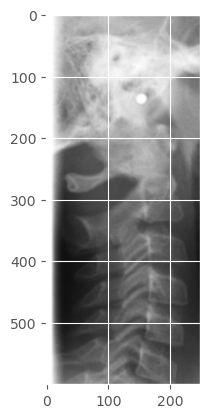

In [6]:
blur = cv2.blur(train_images[0],(3,3))
plt.imshow(blur)

In [7]:
print("Type of train_images", type(train_images))
print("Shape of Training Images",(np.array(train_images).shape),"\n")

print("Type of train_images", type(train_images_hsv))
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")

print("Type of train_coords", type(train_coords))
print("Shape of train_coords",(np.array(train_coords).shape))

Type of train_images <class 'list'>
Shape of Training Images (366, 600, 250, 3) 

Type of train_images <class 'list'>
Shape of Training Images (366, 600, 250, 3) 

Type of train_coords <class 'list'>
Shape of train_coords (366, 38)


In [8]:
## 🟢 Create Validation Data  

In [9]:
val_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')
val_images = []
val_images_rgb_blured = []
val_images_hsv_blured  = []

val_images_enhanced = []
val_images_filtered = []


val_images_hsv = []
val_images_rgb_blured = []
val_images_hsv_blured  = []

val_coords = []

count = 1

for row in val_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    val_x_1_coord = []
    val_y_1_coord = []
    
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    enhanced_image, filtered_image = preprocess_image(gray_image)
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    if count <= 50:
            train_images.append(rgb_resized_image)
            train_images_hsv.append(hsv_resized_image)
            train_images_rgb_blured.append(blured_rgb_resized_image)
            train_images_hsv_blured.append(blured_hsv_resized_image)
            train_images_enhanced.append(enhanced_image)
            train_images_filtered.append(filtered_image)

    else:
            val_images.append(rgb_resized_image)
            val_images_hsv.append(hsv_resized_image)
            val_images_rgb_blured.append(blured_rgb_resized_image)
            val_images_hsv_blured.append(blured_hsv_resized_image)
            val_images_enhanced.append(enhanced_image)
            val_images_filtered.append(filtered_image)
            
    for i in range(0,len(coords)-1,2):
        
        if count <= 50:
            train_x_1_coord.append((coords[i]))
            train_x_1_coord.append((coords[i+1]))
        
        else:
            val_x_1_coord.append((coords[i]))
            val_x_1_coord.append((coords[i+1]))
    if count<=50:
        train_coords.append(np.array(train_x_1_coord))
    else:
        val_coords.append(np.array(val_x_1_coord))

    
    count += 1
    

In [10]:
print("Type of val_images", type(val_images))
print("Shape of val_images ",(np.array(val_images).shape),"\n")

print("Type of val_images", type(val_images_hsv))
print("Shape of val_images ",(np.array(val_images_hsv).shape),"\n")

print("Type of val_coords", type(val_coords))
print("Shape of val_coords",(np.array(val_coords).shape))

Type of val_images <class 'list'>
Shape of val_images  (17, 600, 250, 3) 

Type of val_images <class 'list'>
Shape of val_images  (17, 600, 250, 3) 

Type of val_coords <class 'list'>
Shape of val_coords (17, 38)


In [11]:
test_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')
test_images = []
test_images_rgb_blured = []

test_images_hsv = []
test_images_hsv_blured = []


test_images_enhanced = []
test_images_filtered = []

test_coords = []



for row in test_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    test_x_1_coord = []
    for i in range(0,len(coords)-1,2):
        test_x_1_coord.append((coords[i]))
        test_x_1_coord.append((coords[i+1]))
    test_coords.append(np.array(test_x_1_coord))
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE )
    enhanced_image, filtered_image = preprocess_image(gray_image)
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))

    

    test_images.append(rgb_resized_image)
    test_images_rgb_blured.append(blured_rgb_resized_image)

    test_images_enhanced.append(enhanced_image)
    test_images_filtered.append(filtered_image)

    test_images_hsv.append(hsv_resized_image)
    test_images_hsv_blured.append(blured_hsv_resized_image)

In [12]:
print("Type of test_images", type(test_images))
print("Shape of test_images ",(np.array(test_images).shape),"\n")

print("Type of test_images", type(test_images_hsv))
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")

print("Type of test_coords", type(test_coords))
print("Shape of test_coords",(np.array(test_coords).shape))

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_coords <class 'list'>
Shape of test_coords (67, 38)


In [13]:
print("********* Training Set *********")
print("Shape of Training Images",(np.array(train_images).shape),"\n")
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")
print("Shape of Training  Images",(np.array(train_images_enhanced).shape),"\n")
print("Shape of Training Images",(np.array(train_images_filtered).shape),"\n")
print("Shape of train_coords",(np.array(train_coords).shape),"\n")




print("********* Validation Set *********")
print("Shape of val_images ",(np.array(val_images).shape),"\n")
print("Shape of test_images ",(np.array(val_images_hsv).shape),"\n")
print("Shape of test_images ",(np.array(val_images_enhanced).shape),"\n")
print("Shape of test_images ",(np.array(val_images_filtered).shape),"\n")
print("Shape of val_coords",(np.array(val_coords).shape),"\n")

print("********* Test Set *********")
print("Shape of test_images ",(np.array(test_images).shape),"\n")
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")
print("Shape of test_images ",(np.array(test_images_enhanced).shape),"\n")
print("Shape of test_images ",(np.array(test_images_filtered).shape),"\n")
print("Shape of test_coords",(np.array(test_coords).shape))

********* Training Set *********
Shape of Training Images (416, 600, 250, 3) 

Shape of Training Images (416, 600, 250, 3) 

Shape of Training  Images (416, 600, 250, 3) 

Shape of Training Images (416, 600, 250, 3) 

Shape of train_coords (416, 38) 

********* Validation Set *********
Shape of val_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of val_coords (17, 38) 

********* Test Set *********
Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_coords (67, 38)


In [14]:
train_images_stacked = np.stack(train_images, axis=0)
train_images_rgb_blured_stacked = np.stack(train_images_rgb_blured, axis=0)

train_images_enhanced_stacked = np.stack(train_images_enhanced, axis=0)
train_images_filtered_stacked =  np.stack(train_images_filtered, axis=0)

train_images_hsv_stacked = np.stack(train_images_hsv, axis=0)
train_images_hsv_blured_stacked = np.stack(train_images_hsv_blured, axis=0)



train_labels = np.array(train_coords)

In [15]:
print((train_labels[17]))

[110. 439. 140. 436. 172. 448. 111. 454. 142. 465. 172. 478. 108. 489.
 177. 504. 106. 525. 139. 526. 174. 535. 108. 536. 140. 554. 170. 566.
 105. 571. 169. 594.  99. 607. 129. 614. 156. 626.]


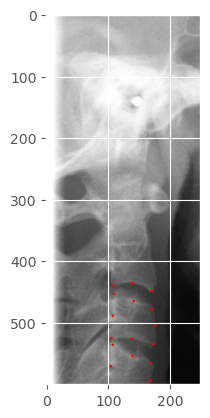

In [16]:
img_num =17
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][0]),int(train_labels[img_num][1])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][2]),int(train_labels[img_num][3])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][4]),int(train_labels[img_num][5])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][6]),int(train_labels[img_num][7])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][8]),int(train_labels[img_num][9])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][10]),int(train_labels[img_num][11])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][12]),int(train_labels[img_num][13])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][14]),int(train_labels[img_num][15])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][16]),int(train_labels[img_num][17])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][18]),int(train_labels[img_num][19])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][20]),int(train_labels[img_num][21])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][22]),int(train_labels[img_num][23])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][24]),int(train_labels[img_num][25])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][26]),int(train_labels[img_num][27])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][28]),int(train_labels[img_num][29])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][30]),int(train_labels[img_num][31])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][32]),int(train_labels[img_num][33])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][34]),int(train_labels[img_num][35])), 2, (255,0,0),-1)
img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][36]),int(train_labels[img_num][37])), 2, (255,0,0),-1)
plt.imshow(img)


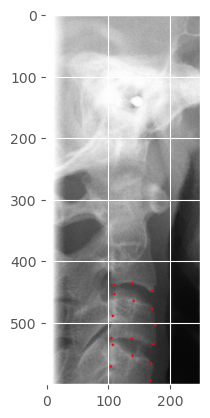

In [17]:
img_ = cv2.circle(train_images_stacked[img_num], (250,600), 2, (255,0,0),-1)
plt.imshow(img_)

In [18]:
val_images_stacked= np.stack(val_images, axis=0)
val_images_rgb_blured_stacked= np.stack(val_images_rgb_blured, axis=0)


val_images_hsv_stacked= np.stack(val_images_hsv, axis=0)
val_images_hsv_blured_stacked= np.stack(val_images_hsv_blured, axis=0)

val_images_enhanced_stacked= np.stack(val_images_enhanced, axis=0)
val_images_filtered_stacked= np.stack(val_images_filtered, axis=0)

val_labels = np.array(val_coords)

val_data = (val_images_stacked,val_labels)
val_data_rgb_blured = (val_images_rgb_blured_stacked,val_labels)                                        

val_data_enhanced = (val_images_enhanced_stacked,val_labels)
val_data_filtered = (val_images_filtered_stacked,val_labels)

val_data_hsv = (val_images_hsv_stacked,val_labels)
val_data_hsv_blured = (val_images_hsv_blured_stacked,val_labels)


In [19]:
test_images_stacked= np.stack(test_images, axis=0)
test_images_rgb_blured_stacked= np.stack(test_images_rgb_blured, axis=0)

test_images_hsv_stacked= np.stack(test_images_hsv, axis=0)
test_images_hsv_blured_stacked= np.stack(test_images_hsv_blured, axis=0)

test_images_enhanced_stacked= np.stack(test_images_enhanced, axis=0)
test_images_filtered_stacked= np.stack(test_images_filtered, axis=0)


test_labels = np.array(test_coords)

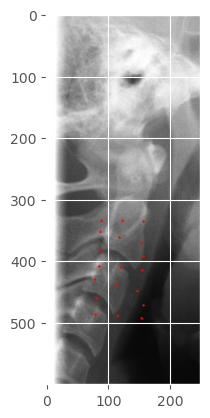

In [20]:
img_num =1
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][0]),int(test_labels[img_num][1])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][2]),int(test_labels[img_num][3])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][4]),int(test_labels[img_num][5])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][6]),int(test_labels[img_num][7])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][8]),int(test_labels[img_num][9])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][10]),int(test_labels[img_num][11])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][12]),int(test_labels[img_num][13])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][14]),int(test_labels[img_num][15])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][16]),int(test_labels[img_num][17])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][18]),int(test_labels[img_num][19])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][20]),int(test_labels[img_num][21])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][22]),int(test_labels[img_num][23])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][24]),int(test_labels[img_num][25])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][26]),int(test_labels[img_num][27])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][28]),int(test_labels[img_num][29])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][30]),int(test_labels[img_num][31])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][32]),int(test_labels[img_num][33])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][34]),int(test_labels[img_num][35])), 2, (255,0,0),-1)
img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][36]),int(test_labels[img_num][37])), 2, (255,0,0),-1)
plt.imshow(img)


In [21]:
print("********* Stacked Training Set *********")
print("Type of train_images_stacked",(type(train_images_stacked)))
print("Shape of train_images_stacked",((train_images_stacked).shape))
print("Shape of train_images_rgb_blured_stacked",((train_images_rgb_blured_stacked).shape))
print("Shape of train_images_hsv_blured_stacked",((train_images_hsv_blured_stacked).shape))
print("Shape of train_images_enhanced_stacked",((train_images_enhanced_stacked).shape))
print("Shape of train_images_filtered_stacked",((train_images_filtered_stacked).shape))
print("Type of train_labels",(type(train_labels)))
print("Shape of train_labels",((train_labels).shape),"\n")

print("********* Stacked Validation Set *********")
print("Shape of val_images_stacked ",((val_images_stacked).shape))
print("Shape of val_images_enhanced_stacked ",((val_images_enhanced_stacked).shape))
print("Shape of val_images_filtered_stacked ",((val_images_filtered_stacked).shape))
print("Shape of val_labels",((val_labels).shape))
print("Val_datet => (val_labels,val_labels)")
print("Type of val_data",(type(val_data)),"\n")

print("********* Stacked Test Set *********")
print("Type of test_labels",(type(test_labels)))
print("Shape of test_images_stacked ",((test_images_stacked).shape))
print("Shape of test_images_enhanced_stacked ",((test_images_enhanced_stacked).shape))
print("Shape of test_images_filtered_stacked ",((test_images_filtered_stacked).shape))
print("Type of test_labels",(type(test_labels)))
print("Shape of test_labels",((test_labels).shape))

********* Stacked Training Set *********
Type of train_images_stacked <class 'numpy.ndarray'>
Shape of train_images_stacked (416, 600, 250, 3)
Shape of train_images_rgb_blured_stacked (416, 600, 250, 3)
Shape of train_images_hsv_blured_stacked (416, 600, 250, 3)
Shape of train_images_enhanced_stacked (416, 600, 250, 3)
Shape of train_images_filtered_stacked (416, 600, 250, 3)
Type of train_labels <class 'numpy.ndarray'>
Shape of train_labels (416, 38) 

********* Stacked Validation Set *********
Shape of val_images_stacked  (17, 600, 250, 3)
Shape of val_images_enhanced_stacked  (17, 600, 250, 3)
Shape of val_images_filtered_stacked  (17, 600, 250, 3)
Shape of val_labels (17, 38)
Val_datet => (val_labels,val_labels)
Type of val_data <class 'tuple'> 

********* Stacked Test Set *********
Type of test_labels <class 'numpy.ndarray'>
Shape of test_images_stacked  (67, 600, 250, 3)
Shape of test_images_enhanced_stacked  (67, 600, 250, 3)
Shape of test_images_filtered_stacked  (67, 600, 250,

In [22]:
def mean_radial_error_landmark(x_true,y_true,x_pred,y_pred):
    delta_x_2 =  np.power( ( np.subtract(x_true , x_pred) ) , 2) #(2,4)
    delta_y_2 =  np.power( ( np.subtract(y_true, y_pred ) ) , 2) #(2,4)

    radial_error_lm_ex = np.sqrt(np.add(delta_x_2,delta_y_2)) #(2,4)

#     print(radial_error_lm_ex)

    radial_error_lm = np.sum(radial_error_lm_ex, axis = 0,keepdims=True) #(1,4)
#     print(radial_error_lm)

    mean_radial_error_lm = radial_error_lm / x_true.shape[0]
#     print(x_true.shape[0])
    
    return radial_error_lm_ex,mean_radial_error_lm

In [23]:
# resnet_model = Sequential()


pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(600,250,3),
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False
# add a global spatial average pooling layer
x = pretrained_model.output
x =  tf.keras.layers.Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# and a linear output layer
prediction = Dense(38, activation='linear')(x)
# this is the model we will train
InceptionResNetV2 = Model(inputs=pretrained_model.input, outputs=prediction)
# resnet_model.add(pretrained_model)

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                patience=5,
                                                min_delta=0.001)

InceptionResNetV2.compile(optimizer=Adam(learning_rate=0.01),loss='mse',metrics=['mae'])

In [25]:
start_time = time.time()
history = InceptionResNetV2.fit(train_images_filtered_stacked,train_labels, validation_data = val_data_filtered, epochs=1000,callbacks=[reduce_lr])
end_time = time.time()
print("Trining_time:",end_time-start_time)

Epoch 1/1000
13/13 [==============================] - 7s 242ms/step - loss: 216308498432.0000 - mae: 132515.0625 - val_loss: 113200056.0000 - val_mae: 9147.7109 - lr: 0.0100
Epoch 2/1000
13/13 [==============================] - 2s 123ms/step - loss: 30844228.0000 - mae: 4322.7427 - val_loss: 6237874.0000 - val_mae: 1983.6833 - lr: 0.0100
Epoch 3/1000
13/13 [==============================] - 2s 123ms/step - loss: 7550591.0000 - mae: 2179.0771 - val_loss: 3462023.2500 - val_mae: 1535.7512 - lr: 0.0100
Epoch 4/1000
13/13 [==============================] - 2s 122ms/step - loss: 3433438.2500 - mae: 1500.3397 - val_loss: 3353469.2500 - val_mae: 1579.3446 - lr: 0.0100
Epoch 5/1000
13/13 [==============================] - 2s 121ms/step - loss: 1957304.0000 - mae: 1121.5684 - val_loss: 1426374.5000 - val_mae: 1020.9263 - lr: 0.0100
Epoch 6/1000
13/13 [==============================] - 2s 123ms/step - loss: 776500.6250 - mae: 677.5891 - val_loss: 314363.3438 - val_mae: 435.4258 - lr: 0.0100
Epoc

In [26]:
InceptionResNetV2.save('incep_adabtiveLR_1000_filtered.h5')

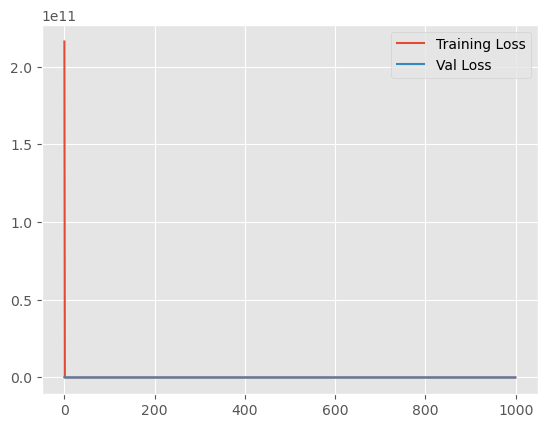

In [27]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.legend()
plt.show()

In [28]:
start_time = time.time()

prediction_IncepRes=InceptionResNetV2.predict(test_images_filtered_stacked)

end_time =  time.time()

print("prediction_time:",end_time-start_time)


3/3 [==============================] - 2s 135ms/step
prediction_time: 1.6495039463043213


In [29]:
print("Mean Absolute Error: ",MAE_SKL(test_labels, prediction_IncepRes))

Mean Absolute Error:  78.03976452978036


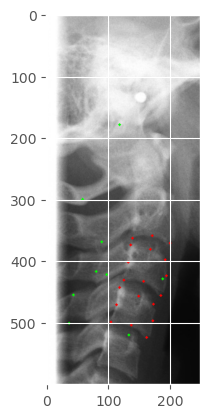

In [30]:
img_number = 56
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[img_number])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

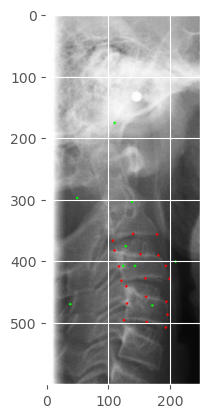

In [31]:
img_number = 55
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[img_number])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

[ 73.62813  213.13132   86.745224 250.87848   56.41773  310.6234
  42.202126 267.33078   18.989367 276.32083  115.88756  416.7385
 100.73506  269.23367   78.5227   298.33878   95.03118  336.35873
  94.18813  278.49374   85.73307  360.98227  152.03201  428.16318
 201.17361  227.01076  150.5874   435.21133  -18.093164 347.6566
  83.179    391.20624   55.09585  374.6269    29.323967 374.9173
 132.6433   367.2837  ]


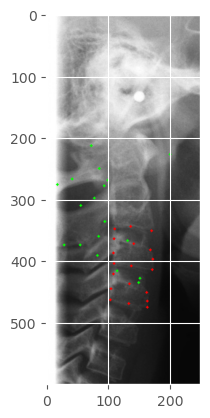

In [32]:
img_number = 29
print(prediction_IncepRes[img_number])
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[4])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)